# Eon Labs
## Seyed Arman Abtahi

The data engineering team at Eon Labs conducted some study and discovered that the Google Trends data may be useful to the data science team. I, as a data scientist, require a time series of reliable Google Trends data with hourly intervals from 2018 to the present. I alerted the technical staff of this demand, but they stated that they could not directly retrieve the hourly data. The Deep Dive section explains why they are unable to directly retrieve the hourly data. However, they may obtain the following raw data from Google Trends:

- **hourly_data.csv:** a time series of weekly-consistent Google Trends data starting in 2017 and continuing up to the present, with hourly intervals
- **weekly_data.csv:** a time series of yearly-consistent Google Trends data starting in 2017 and continuing up to the present, with weekly intervals
- **monthly_data.csv:** a time series of consistent Google Trends data starting in 2017 and continuing up to the present, with monthly intervals

They retrieved and concatenated week-range data to obtain a time series of hourly data from 2017 to the present.

They retrieved and concatenated year-range data to obtain the weekly interval time series from 2017 to the present.

By selecting a time range of 2017-present, the engineering team discovered that they could only produce time series of consistent Google Trends data with time intervals of months.

How do you utilise the data files'monthly data.csv,' 'weekly data.csv,' and 'hourly data.csv' provided by the engineering team to generate **time series of consistent Google Trends data from 2018 to the present with time intervals of hours**?

In [1]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
df_h = pd.read_csv("hourly_data.csv")
df_w = pd.read_csv("weekly_data.csv")
df_m = pd.read_csv("monthly_data.csv")

Removing 2017 data!

In [3]:
df_h=df_h[df_h["date"]>'2017-12-31 23:00:00'].reset_index(drop=True)
df_w=df_w[df_w["date"]>'2017-12-31'].reset_index(drop=True)
df_m=df_m[df_m["date"]>'2017-12-31'].reset_index(drop=True)

How does the trend look like?

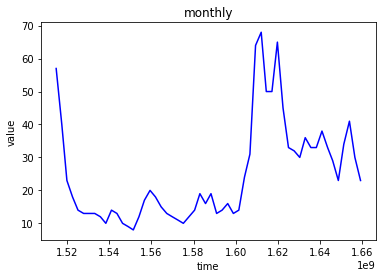

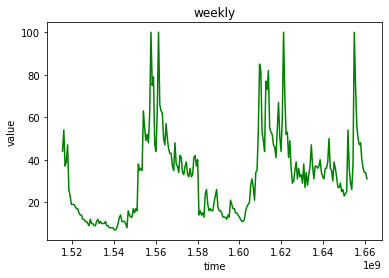

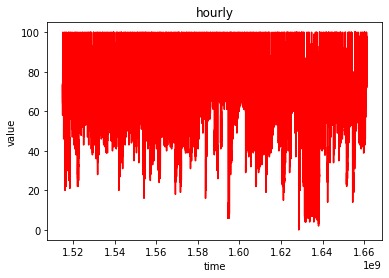

In [4]:
plt.figure(1)
plt.plot(df_m["time_month"], df_m["value_month"], "b-", label="monthly value")
plt.ylabel("value")
plt.xlabel("time")
plt.title("monthly");
plt.figure(2)
plt.plot(df_w["time_week"], df_w["value_week"], "g-", label="weekly value")
plt.ylabel("value")
plt.xlabel("time")
plt.title("weekly");
plt.figure(3)
plt.plot(df_h["time_hour"], df_h["value_hour"], "r-", label="hourly value")
plt.ylabel("value")
plt.xlabel("time")
plt.title("hourly");

Obviously weekly and hourly data are not consistent.
Case study for separate years:

In [5]:
Years=list(range(2018,2023))

In [6]:
df_dict={}
for year in Years:
    df_dict["df_m_"+str(year)]=df_m[(df_m["date"]<str(year+1)+'-01-01')&(df_m["date"]>str(year-1)+'-12-31')].reset_index(drop=True)
    df_dict["df_w_"+str(year)]=df_w[(df_w["date"]<str(year+1)+'-01-01')&(df_w["date"]>str(year-1)+'-12-31')].reset_index(drop=True)

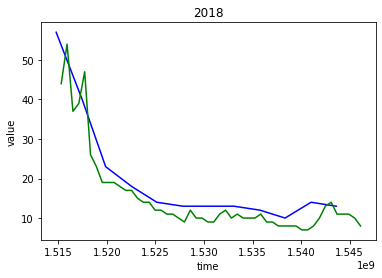

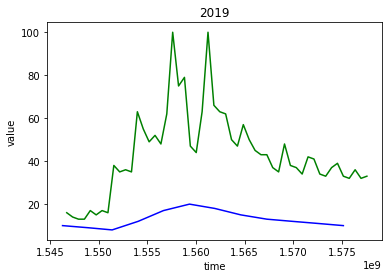

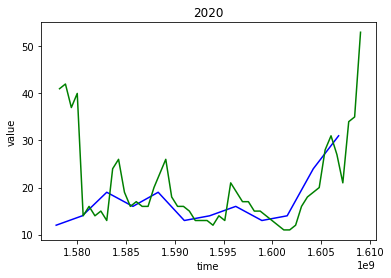

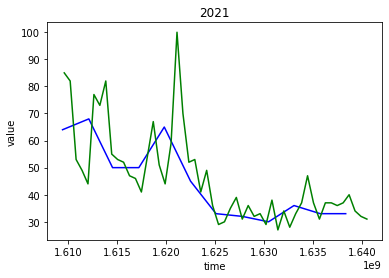

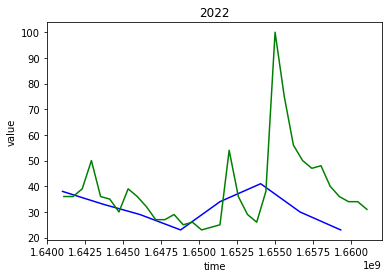

In [7]:
for i, year in enumerate(Years):
    plt.figure(i)
    plt.plot(df_dict["df_m_"+str(year)]["time_month"], df_dict["df_m_"+str(year)]["value_month"], "b-", label="monthly value")
    plt.plot(df_dict["df_w_"+str(year)]["time_week"], df_dict["df_w_"+str(year)]["value_week"], "g-", label="weekly value")
    plt.ylabel("value")
    plt.xlabel("time")
    plt.title(str(year));

Now we can "normalize" the weekly data, so that their means match the yearly means.

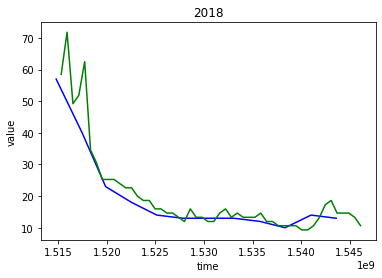

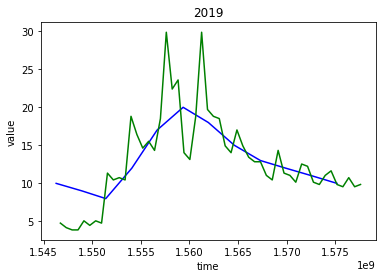

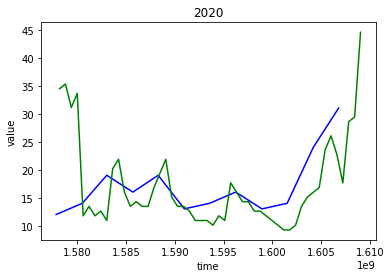

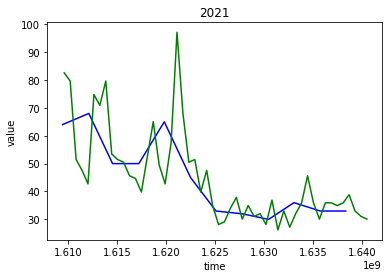

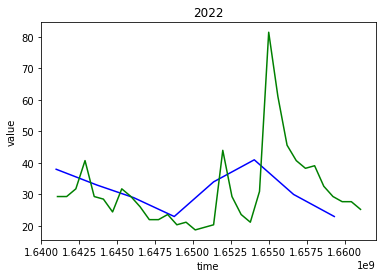

In [8]:
Normal_week=[]
for i, year in enumerate(Years):
    mean_month=df_dict["df_m_"+str(year)]["value_month"].mean()
    mean_week=df_dict["df_w_"+str(year)]["value_week"].mean()
    Normal_week.append(mean_month/mean_week)
    
    df_dict["df_w_"+str(year)]["value_week"]=df_dict["df_w_"+str(year)]["value_week"]*(mean_month/mean_week)
    
    plt.figure(i)
    plt.plot(df_dict["df_m_"+str(year)]["time_month"], df_dict["df_m_"+str(year)]["value_month"], "b-", label="monthly value")
    plt.plot(df_dict["df_w_"+str(year)]["time_week"], df_dict["df_w_"+str(year)]["value_week"], "g-", label="weekly value")
    plt.ylabel("value")
    plt.xlabel("time")
    plt.title(str(year));

Hoora! Weekly values are consistent now. Let's concatenate data back again

In [9]:
df_w_scaled=df_dict["df_w_2018"]
for year in Years[1:]:
    df_w_scaled=pd.concat([df_w_scaled,df_dict["df_w_"+str(year)]], sort=False).reset_index(drop=True)

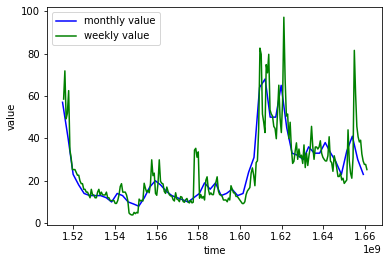

In [10]:
plt.figure(1)
plt.plot(df_m["time_month"], df_m["value_month"], "b-", label="monthly value")
plt.plot(df_w_scaled["time_week"], df_w_scaled["value_week"], "g-", label="weekly value")
plt.ylabel("value")
plt.xlabel("time")
plt.legend()

We do the same thing for hourly data

In [11]:
df_h_scaled=df_h.copy()
prev_date="2017-12-31"
for i in range(df_w_scaled.shape[0]):
    next_date=df_w_scaled.loc[i,"date"]
    mean_week=df_w_scaled.loc[i,"value_week"]
    mean_hour=df_h[(df_h["date"]<next_date)&(df_h["date"]>prev_date)]["value_hour"].mean()
    week=df_h[(df_h["date"]<next_date)&(df_h["date"]>prev_date)]["value_hour"]*(mean_week/mean_hour)
    df_h_scaled.loc[week.index,"value_hour"]=week
    prev_date=next_date

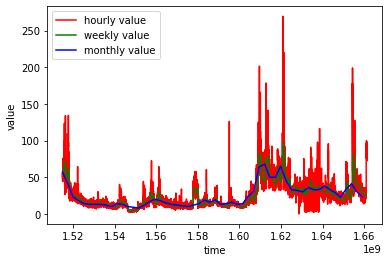

In [12]:
plt.figure(1)
plt.plot(df_h_scaled["time_hour"], df_h_scaled["value_hour"], "r-", label="hourly value")
plt.plot(df_w_scaled["time_week"], df_w_scaled["value_week"], "g-", label="weekly value")
plt.plot(df_m["time_month"], df_m["value_month"], "b-", label="monthly value")
plt.ylabel("value")
plt.xlabel("time")
plt.legend()

In [13]:
df_h_scaled["value_hour"].min()

0.0

In [14]:
df_h_scaled["value_hour"].max()

269.59146853396686